In [6]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from time import time
import logging

import numpy as np
import pandas as pd

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

sns.set_style('white')
np.random.seed(42)

def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

In [7]:
sec_path = Path('data', 'sec-filings')
ngram_path = sec_path / 'ngrams'
results_path = Path('results', 'sec-filings')

model_path = results_path / 'models'
if not model_path.exists():
    model_path.mkdir(parents=True)

log_path = results_path / 'logs'
if not log_path.exists():
    log_path.mkdir(parents=True)

logging.basicConfig(filename=log_path / 'word2vec.log', level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')

In [8]:
# word2vec
analogies_path = Path('data', 'analogies-en.txt')

In [9]:
# Set up Sentence Generator
NGRAMS = 2

sentence_path = ngram_path  / f'ngrams_{NGRAMS}.txt'
sentences = LineSentence(sentence_path)

In [10]:
# Train word2vec Model
start = time()
model = Word2Vec(sentences,
                 sg=1,          # 1 for skip-gram; otherwise CBOW
                 hs=0,          # hierarchical softmax if 1, negative sampling if 0
                 vector_size=300,      # Vector dimensionality
                 window=5,      # Max distance betw. current and predicted word
                 min_count=50,  # Ignore words with lower frequency
                 negative=15,    # noise word count for negative sampling
                 workers=4,     # no threads
                 epochs=1,        # no epochs = iterations over corpus
                 alpha=0.05,   # initial learning rate
                 min_alpha=0.0001 # final learning rate
                )
print('Duration:', format_time(time() - start))

Duration: 00:26:21


In [83]:
# ersist model & vectors
model.save((model_path / 'word2vec_0.model').as_posix())
model.wv.save((model_path / 'word_vectors_0.bin').as_posix())

# Load model and vectors
model = Word2Vec.load((model_path / 'word2vec_0.model').as_posix())
wv = KeyedVectors.load((model_path / 'word_vectors_0.bin').as_posix())

# Get vocabulary
# code usage has been updated at gensim version over 4.0
vocab = []
for k, v in model.wv.key_to_index.items():
    # be aware of different word btw get_vector() & get_vecattr()
    vocab.append([k, v, model.wv.get_vecattr(k, "count")])

# gensim usage for below 4.0
# for k, _ in model.wv.vocab.items():
#     v_ = model.wv.vocab[k]
#     vocab.append([k, v_.index, v_.count])

vocab = (pd.DataFrame(vocab, columns=['token', 'idx', 'count']).sort_values('count', ascending=False))
vocab.info()

[['million', 0, 2341139]]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 57661 entries, 0 to 57660
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   token   57661 non-null  object
 1   idx     57661 non-null  int64 
 2   count   57661 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [84]:
vocab.head(10)

,token,idx,count
0,million,0,2341139
1,business,1,1702656
2,december,2,1519278
3,company,3,1491442
4,products,4,1368864
5,net,5,1254712
6,market,6,1149272
7,including,7,1109873
8,sales,8,1099668
9,costs,9,1020150


In [85]:
vocab['count'].describe(percentiles=np.arange(.1, 1, .1)).astype(int)

count      57661
mean        4515
std        35183
min           50
10%           60
20%           75
30%           96
40%          127
50%          175
60%          262
70%          440
80%          942
90%         3657
max      2341139
Name: count, dtype: int32

In [88]:
# Evaluate Analogies
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='Total accuracy', ['correct', 'incorrect', 'average']].squeeze().tolist()

score, detailed_accuracy = model.wv.evaluate_word_analogies(analogies_path.as_posix(), case_insensitive=True)
summary = accuracy_by_category(detailed_accuracy)

                       category  correct  incorrect   average
10  gram6-nationality-adjective      477        645  0.425134
12                 gram8-plural      263        667  0.282796
7             gram3-comparative      280        842  0.249554
9      gram5-present-participle      137        415  0.248188
2                 city-in-state      993       3249  0.234088
14               Total accuracy     2529       8817  0.222898
13           gram9-plural-verbs       83        297  0.218421
5     gram1-adjective-to-adverb       64        356  0.152381
6                gram2-opposite       46        296  0.134503
11             gram7-past-tense      102        768  0.117241
8             gram4-superlative       44        462  0.086957
0      capital-common-countries       18        222  0.075000
4                        family        4         68  0.055556
1                 capital-world       12        330  0.035088
3                      currency        6        200  0.029126


In [89]:
def eval_analogies(w2v, max_vocab=15000):
    score, accuracy = w2v.wv.evaluate_word_analogies(analogies_path, restrict_vocab=15000,
                               case_insensitive=True)
    return (pd.DataFrame([[c['section'], len(c['correct']), len(c['incorrect'])] for c in accuracy],
                      columns=['category', 'correct', 'incorrect'])
          .assign(average=lambda x: x.correct.div(x.correct.add(x.incorrect))))

def total_accuracy(w2v):
    df = eval_analogies(w2v)
    return df.loc[df.category == 'Total accuracy', ['correct', 'incorrect', 'average']].squeeze().tolist()
accuracy = eval_analogies(model)
accuracy

,category,correct,incorrect,average
0,capital-common-countries,2,10,0.166667
1,capital-world,0,0,NaN
2,city-in-state,250,474,0.345304
3,currency,2,50,0.038462
4,family,0,0,NaN
5,gram1-adjective-to-adverb,45,165,0.214286
6,gram2-opposite,19,71,0.211111
7,gram3-comparative,238,362,0.396667
8,gram4-superlative,19,71,0.211111
9,gram5-present-participle,107,199,0.349673


In [90]:
# Validate Vector Arithmetic
sims=model.wv.most_similar(positive=['iphone'], restrict_vocab=15000)
print(pd.DataFrame(sims, columns=['term', 'similarity']))

                  term  similarity
0                 ipad    0.708613
1              android    0.654367
2                  app    0.615558
3          smartphones    0.604784
4           smartphone    0.598609
5  smartphones_tablets    0.556871
6       mobile_devices    0.546527
7         smart_phones    0.540127
8          smart_phone    0.539178
9             keyboard    0.535181


In [91]:
analogy = model.wv.most_similar(positive=['france', 'london'], negative=['paris'], restrict_vocab=15000)
print(pd.DataFrame(analogy, columns=['term', 'similarity']))

             term  similarity
0         germany    0.580225
1  united_kingdom    0.556751
2  germany_france    0.520393
3          poland    0.510427
4         belgium    0.505797
5     netherlands    0.505068
6       australia    0.503371
7  czech_republic    0.496944
8          sweden    0.493358
9         austria    0.491993


In [92]:
# Check similarity for random words
VALID_SET = 5  # Random set of words to get nearest neighbors for
VALID_WINDOW = 100  # Most frequent words to draw validation set from
valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)
similars = pd.DataFrame()

for id in sorted(valid_examples):
    word = vocab.loc[id, 'token']
    similars[word] = [s[0] for s in model.wv.most_similar(word)]

similars

,addition,information,credit,table_contents,activities
0,additionally,data,revolving_credit,addition,activity
1,furthermore,details,omfh,additionally,operations
2,example,stored_transmitted,revolving,baylake_corp,investing_activities
3,table_contents,inference_drawn,lenders,december,financing_activities
4,finally,nformation,credit_facility,stag_predecessor,investing
5,including,disclosure,sublimit_swing,s,activites
6,result,disclosed,loan,premierwest,efforts
7,similarly,annual_report,borrowing,included,adjustments_reconcile
8,connection,discussion,lending,following,fhcs
9,accordingly,transmitting_storing,standings,including,engage


In [94]:
# Continue Training
accuracies = [summary]
best_accuracy = summary[-1]
for i in range(1, 15):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    score, detailed_accuracy = model.wv.evaluate_word_analogies(analogies_path)
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print(f'{i:02} | Duration: {format_time(time() - start)} | Accuracy: {accuracies[-1][-1]:.2%} ')
    if accuracies[-1][-1] > best_accuracy:
        model.save((model_path / f'word2vec_{i:02}.model').as_posix())
        model.wv.save((model_path / f'word_vectors_{i:02}.bin').as_posix())
        best_accuracy = accuracies[-1][-1]

    (pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average'])
     .to_csv(model_path / 'accuracies.csv', index=False))

model.wv.save((model_path / 'word_vectors_final.bin').as_posix())

01 | Duration: 00:25:03 | Accuracy: 29.04% 
02 | Duration: 00:23:18 | Accuracy: 29.46% 
03 | Duration: 00:23:04 | Accuracy: 29.61% 
04 | Duration: 00:22:57 | Accuracy: 30.04% 
05 | Duration: 00:23:17 | Accuracy: 30.04% 
06 | Duration: 00:22:48 | Accuracy: 30.23% 
07 | Duration: 00:22:19 | Accuracy: 29.22% 
08 | Duration: 00:22:19 | Accuracy: 30.34% 
09 | Duration: 00:22:45 | Accuracy: 30.29% 
10 | Duration: 00:22:42 | Accuracy: 30.78% 
11 | Duration: 00:22:48 | Accuracy: 30.05% 
12 | Duration: 00:22:31 | Accuracy: 30.81% 
13 | Duration: 00:22:41 | Accuracy: 30.53% 
14 | Duration: 00:23:42 | Accuracy: 29.90% 


In [97]:
# Sample Output
(pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average'])
 .to_csv(results_path / 'accuracies.csv', index=False))
best_model = Word2Vec.load((results_path / 'models/word2vec_12.model').as_posix())
score, detailed_accuracy = best_model.wv.evaluate_word_analogies(analogies_path.as_posix(), case_insensitive=True)
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect   average
10  gram6-nationality-adjective      592        530  0.527629
2                 city-in-state     1590       2652  0.374823
12                 gram8-plural      335        595  0.360215
9      gram5-present-participle      171        381  0.309783
14               Total accuracy     3496       7850  0.308126
7             gram3-comparative      334        788  0.297683
13           gram9-plural-verbs       90        290  0.236842
5     gram1-adjective-to-adverb       75        345  0.178571
0      capital-common-countries       39        201  0.162500
11             gram7-past-tense      132        738  0.151724
6                gram2-opposite       51        291  0.149123
1                 capital-world       42        300  0.122807
8             gram4-superlative       37        469  0.073123
4                        family        3         69  0.041667
3                      currency        5        201  0.024272
Base Acc

In [102]:
cat_dict = {'capital-common-countries':'Capitals',
            'capital-world':'Capitals RoW',
            'city-in-state':'City-State',
            'currency':'Currency',
            'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb',
            'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative',
            'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.',
            'gram6-nationality-adjective':'Natisonality',
            'gram7-past-tense':'Past Tense',
            'gram8-plural':'Plural',
            'gram9-plural-verbs':'Plural Verbs',
            'Total accuracy':'Total accuracy'}

In [103]:
results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in detailed_accuracy]
results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
results['category'] = results.category.map(cat_dict)
results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
results = results.rename(columns=str.capitalize).set_index('Category')
total = results.loc['Total accuracy']
results = results.drop('Total accuracy')

In [107]:
total

Correct      3496.000000
Incorrect    7850.000000
Average         0.308126
Name: Total accuracy, dtype: float64

In [104]:
most_sim = best_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,women,0.391287
1,spalding,0.372898
2,kids,0.368618
3,st_mary,0.362969
4,magazine,0.340280
5,college,0.338167
6,female,0.337399
7,michelle,0.333034
8,love,0.327213
9,baby,0.327128


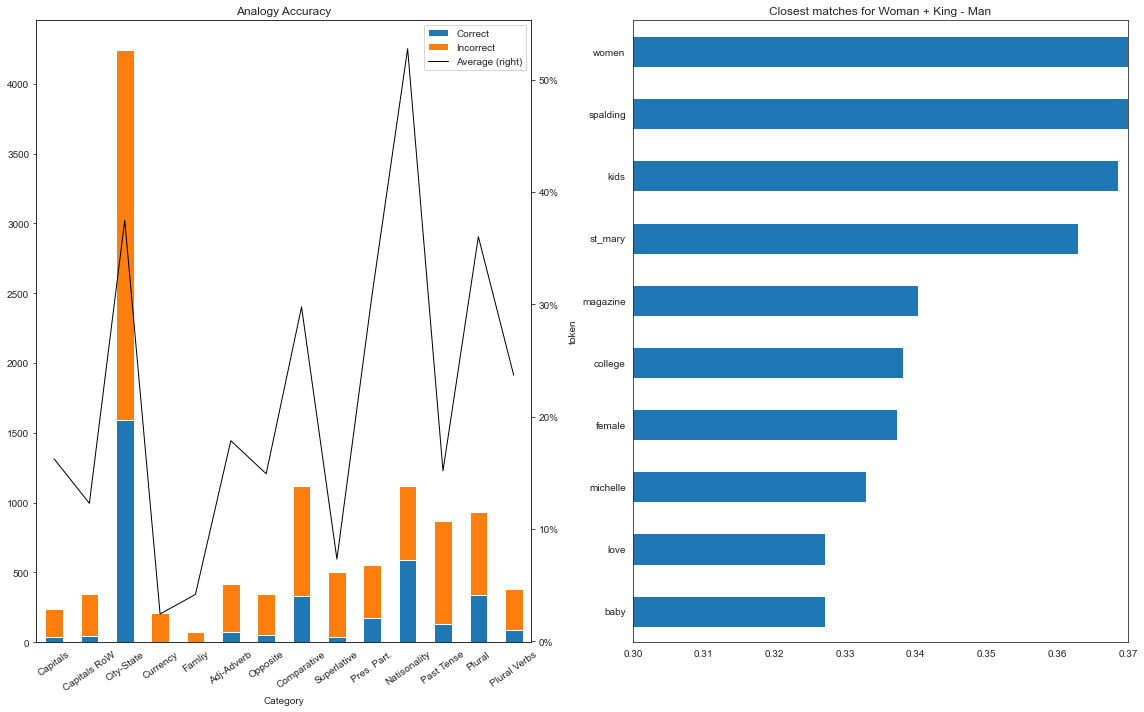

In [105]:
fig, axes = plt.subplots(figsize=(16, 10), ncols=2)

axes[0] = results.loc[:, ['Correct', 'Incorrect']].plot.bar(stacked=True, ax=axes[0] , title='Analogy Accuracy')
ax1 = results.loc[:, ['Average']].plot(ax=axes[0], secondary_y=True, lw=1, c='k', rot=35)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

(pd.DataFrame(most_sim, columns=['token', 'similarity']).set_index('token').similarity
 .sort_values().tail(10).plot.barh(xlim=(.3, .37), ax=axes[1], title='Closest matches for Woman + King - Man'))

fig.tight_layout();